# Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [4]:
import sys
sys.path.append("..")
import grading
import download_utils

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [6]:
# we downloaded them for you, just link them here
download_utils.link_week_4_resources()

In [7]:
X, attr = load_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

A Jupyter Widget

X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


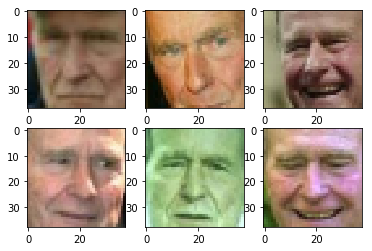

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



In [9]:
import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()

Using TensorFlow backend.


## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [10]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model

In [11]:
encoder,decoder = build_pca_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [12]:
autoencoder.fit(x=X_train,y=X_train,epochs=32, verbose=2,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
4s - loss: 0.0294 - val_loss: 0.0199
Epoch 2/32
3s - loss: 0.0174 - val_loss: 0.0152
Epoch 3/32
3s - loss: 0.0141 - val_loss: 0.0129
Epoch 4/32
3s - loss: 0.0123 - val_loss: 0.0114
Epoch 5/32
4s - loss: 0.0108 - val_loss: 0.0101
Epoch 6/32
3s - loss: 0.0097 - val_loss: 0.0091
Epoch 7/32
3s - loss: 0.0088 - val_loss: 0.0082
Epoch 8/32
3s - loss: 0.0080 - val_loss: 0.0076
Epoch 9/32
3s - loss: 0.0075 - val_loss: 0.0074
Epoch 10/32
3s - loss: 0.0072 - val_loss: 0.0070
Epoch 11/32
4s - loss: 0.0071 - val_loss: 0.0069
Epoch 12/32
4s - loss: 0.0070 - val_loss: 0.0071
Epoch 13/32
3s - loss: 0.0070 - val_loss: 0.0071
Epoch 14/32
3s - loss: 0.0069 - val_loss: 0.0068
Epoch 15/32
3s - loss: 0.0069 - val_loss: 0.0069
Epoch 16/32
4s - loss: 0.0069 - val_loss: 0.0069
Epoch 17/32
3s - loss: 0.0069 - val_loss: 0.0068
Epoch 18/32
3s - loss: 0.0069 - val_loss: 0.0068
Epoch 19/32
4s - loss: 0.0069 - val_loss: 0.0068
Epoch 20/32
4s - loss: 0.0069

In [13]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


Final MSE: 0.00685766047936


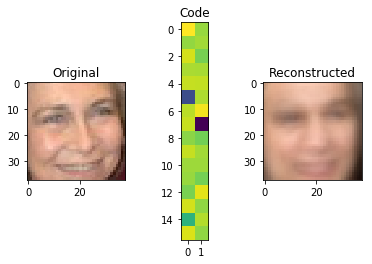

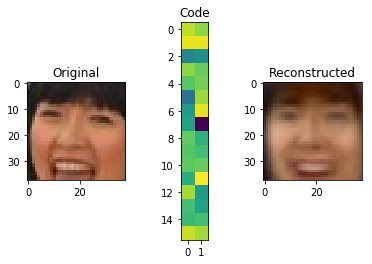

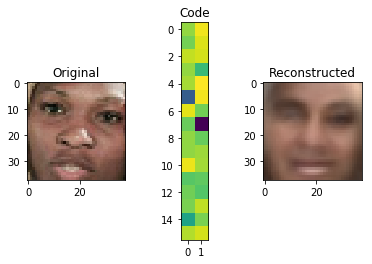

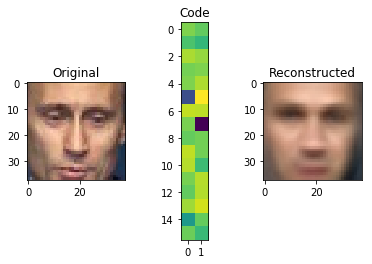

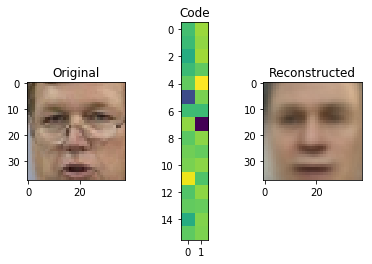

In [14]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [15]:
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    l1 = max(min(code_size*12, 384), code_size)
    l2 = max(min(code_size*4, 256), code_size)
    l3 = max(min(code_size*2, 64), code_size)
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(l1))
    encoder.add(L.advanced_activations.LeakyReLU(0.01))
    encoder.add(L.Dense(l2))
    encoder.add(L.advanced_activations.LeakyReLU(0.01))
    encoder.add(L.Dense(l3))
    encoder.add(L.advanced_activations.LeakyReLU(0.01))
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(l3))
    decoder.add(L.advanced_activations.LeakyReLU(0.01))
    decoder.add(L.Dense(l2))
    decoder.add(L.advanced_activations.LeakyReLU(0.01))
    decoder.add(L.Dense(l1))
    decoder.add(L.advanced_activations.LeakyReLU(0.01))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
  
    return encoder,decoder

In [ ]:
'''
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu')) # 36*36*32
    encoder.add(L.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')) # 36*36*64
    encoder.add(L.pooling.MaxPool2D((2,2)))                                                        # 18*18*64    
    encoder.add(L.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))#18*18*128
    encoder.add(L.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))#18*18*128
    encoder.add(L.pooling.MaxPool2D((2,2)))                                                        #9*9*128
    encoder.add(L.Flatten())             #flatten image to vector
    encoder.add(L.Dense(code_size*4))           
    encoder.add(L.Activation('relu'))
    encoder.add(L.Dense(code_size))           #actual encoder
    
    #<Your code: define encoder as per instructions above>
    
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))

    #<Your code: define encoder as per instructions above>
    decoder.add(L.Dense(code_size*4))  
    decoder.add(L.Activation('relu'))
    decoder.add(L.Dense(9*9*128))   #8*8*128
    decoder.add(L.Activation('relu'))
    decoder.add(L.Reshape((9,9,128)))  # 9*9*128
    decoder.add(L.UpSampling2D(size=2)) # 18*18*128
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')) # 18*18*128
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')) # 18*18*64
    decoder.add(L.UpSampling2D(size=2))                                                                     #36*36*64
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')) # 36*36*32
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='valid', activation='relu')) # 38*38*3

    
  
    return encoder,decoder
'''

In [16]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 dense layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 dense layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [17]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [18]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 38, 38, 3)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4332)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 384)               1663872   
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 384)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               49280     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
__________

Training may take some 20 minutes.

In [19]:
autoencoder.fit(x=X_train,y=X_train,epochs=32, verbose=2,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
26s - loss: 0.0212 - val_loss: 0.0138
Epoch 2/32
26s - loss: 0.0132 - val_loss: 0.0123
Epoch 3/32
26s - loss: 0.0117 - val_loss: 0.0111
Epoch 4/32
26s - loss: 0.0109 - val_loss: 0.0106
Epoch 5/32
25s - loss: 0.0104 - val_loss: 0.0103
Epoch 6/32
23s - loss: 0.0100 - val_loss: 0.0099
Epoch 7/32
23s - loss: 0.0097 - val_loss: 0.0096
Epoch 8/32
24s - loss: 0.0094 - val_loss: 0.0092
Epoch 9/32
25s - loss: 0.0091 - val_loss: 0.0092
Epoch 10/32
26s - loss: 0.0089 - val_loss: 0.0089
Epoch 11/32
24s - loss: 0.0087 - val_loss: 0.0085
Epoch 12/32
24s - loss: 0.0085 - val_loss: 0.0087
Epoch 13/32
25s - loss: 0.0084 - val_loss: 0.0085
Epoch 14/32
24s - loss: 0.0083 - val_loss: 0.0083
Epoch 15/32
24s - loss: 0.0081 - val_loss: 0.0081
Epoch 16/32
24s - loss: 0.0080 - val_loss: 0.0080
Epoch 17/32
24s - loss: 0.0078 - val_loss: 0.0079
Epoch 18/32
25s - loss: 0.0077 - val_loss: 0.0080
Epoch 19/32
25s - loss: 0.0077 - val_loss: 0.0078
Epoch 20/3

Final MSE: 0.0049


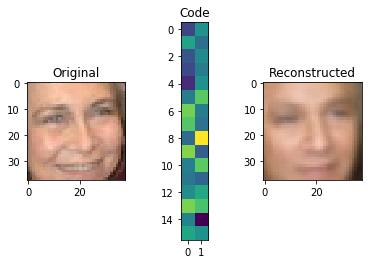

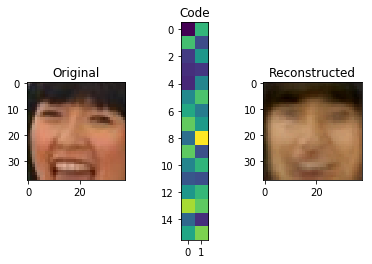

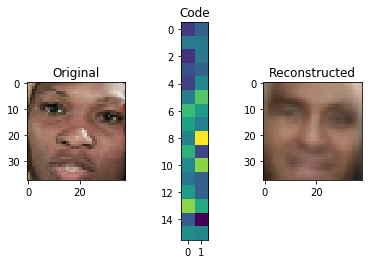

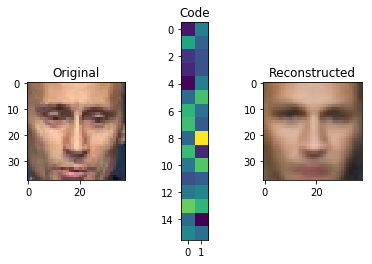

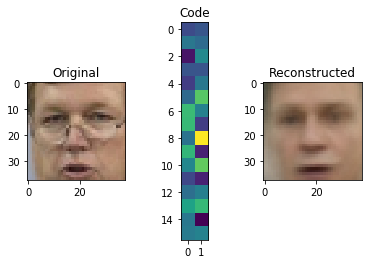

In [20]:
reconstruction_mse = autoencoder.evaluate(X_test,X_test,verbose=0)
reconstruction_mse = 0.0049
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [21]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    #<your code here>
    noise = np.random.standard_normal(X.shape)*sigma
        
    return X + noise
    

In [22]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

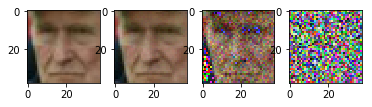

In [23]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [24]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [25]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

Epoch 0/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 269s - loss: 0.304 - ETA: 156s - loss: 0.270 - ETA: 118s - loss: 0.851 - ETA: 98s - loss: 0.671 - ETA: 87s - loss: 0.57 - ETA: 80s - loss: 0.51 - ETA: 75s - loss: 0.45 - ETA: 71s - loss: 0.41 - ETA: 67s - loss: 0.38 - ETA: 64s - loss: 0.34 - ETA: 62s - loss: 0.32 - ETA: 60s - loss: 0.29 - ETA: 58s - loss: 0.27 - ETA: 57s - loss: 0.26 - ETA: 56s - loss: 0.24 - ETA: 55s - loss: 0.23 - ETA: 54s - loss: 0.22 - ETA: 53s - loss: 0.21 - ETA: 52s - loss: 0.20 - ETA: 52s - loss: 0.19 - ETA: 51s - loss: 0.18 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.17 - ETA: 50s - loss: 0.16 - ETA: 50s - loss: 0.15 - ETA: 49s - loss: 0.15 - ETA: 49s - loss: 0.14 - ETA: 49s - loss: 0.14 - ETA: 49s - loss: 0.14 - ETA: 48s - loss: 0.13 - ETA: 48s - loss: 0.13 - ETA: 48s - loss: 0.12 - ETA: 48s - loss: 0.12 - ETA: 47s - loss: 0.12 - ETA: 47s - loss: 0.12 - ETA: 47s - loss: 0.11 - ETA: 47s - loss: 0.11 - ETA: 46s - loss: 0.11 - ETA: 46s - loss: 0.11 - ETA: 46s -

10880/11828 [==========================>...] - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 37s - loss: 0.01 - ETA: 37s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 37s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 3s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 1s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - 42s - loss: 0.0143 - val_loss: 0.0131
Epoch 2/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 33s - loss: 

10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 36s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 35s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 34s - loss: 0.01 - ETA: 33s - loss: 0.01 - ETA: 33s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.011 - ETA: 3s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 2s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - ETA: 0s - loss: 0.011 - 42s - loss: 0.0111 - val_loss: 0.0108
Epoch 4/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 43s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 42s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 40s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 38s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 39s - loss: 0.01 - ETA: 38s - loss: 0.01 - ETA: 38s - loss: 0.01 - ETA: 38s - loss: 0.01 - ETA: 38s - loss: 0.01 - ETA: 38s - loss: 0.01 - ETA: 38s - loss: 0.01 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 41s - loss: 0.01 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 3s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 2s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 1s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - ETA: 0s - loss: 0.009 - 48s - loss: 0.0098 - val_loss: 0.0092
Epoch 6/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 

10880/11828 [==========================>...] - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 48s - loss: 0.0088 - val_loss: 0.0085
Epoch 8/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 37s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 43s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 3s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 2s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 1s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - ETA: 0s - loss: 0.008 - 49s - loss: 0.0082 - val_loss: 0.0080
Epoch 10/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 44s - loss: 0.00 - ETA: 46s - loss: 0.00 - ETA: 47s - loss: 0.00 - ETA: 49s - loss: 0.00 - ETA: 48s - loss: 0.00 - ETA: 47s - loss: 0.00 - ETA: 46s - loss: 0.00 - ETA: 45s - loss: 0.00 - ETA: 45s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 47s - loss: 0.0076 - val_loss: 0.0073
Epoch 12/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 42s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 3s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 2s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 1s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 47s - loss: 0.0072 - val_loss: 0.0072
Epoch 14/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 43s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 47s - loss: 0.0069 - val_loss: 0.0068
Epoch 16/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 47s - loss: 0.0066 - val_loss: 0.0067
Epoch 18/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 43s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 47s - loss: 0.0064 - val_loss: 0.0067
Epoch 20/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 47s - loss: 0.0062 - val_loss: 0.0063
Epoch 22/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.006 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.006 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 47s - loss: 0.0060 - val_loss: 0.0062
Epoch 24/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 47s - loss: 0.0059 - val_loss: 0.0061
Epoch 26/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 39s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 47s - loss: 0.0057 - val_loss: 0.0060
Epoch 28/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 47s - loss: 0.0056 - val_loss: 0.0060
Epoch 30/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 47s - loss: 0.0055 - val_loss: 0.0059
Epoch 32/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 

10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 48s - loss: 0.0054 - val_loss: 0.0057
Epoch 34/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 44s - loss: 0.0054 - val_loss: 0.0059
Epoch 36/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 44s - loss: 0.0054 - val_loss: 0.0058
Epoch 38/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

10880/11828 [==========================>...] - ETA: 38s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 46s - loss: 0.0053 - val_loss: 0.0057
Epoch 40/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 34s - loss: 0.00 - ETA: 34s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 45s - loss: 0.0052 - val_loss: 0.0062
Epoch 42/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 

10880/11828 [==========================>...] - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 44s - loss: 0.0051 - val_loss: 0.0057
Epoch 44/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 0.00 - ETA: 37s - loss: 

10880/11828 [==========================>...] - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 36s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 51s - loss: 0.0050 - val_loss: 0.0057
Epoch 46/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 44s - loss: 

10880/11828 [==========================>...] - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 48s - loss: 0.0050 - val_loss: 0.0058
Epoch 48/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1


10880/11828 [==========================>...] - ETA: 38s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 

10880/11828 [==========================>...] - ETA: 44s - loss: 0.00 - ETA: 42s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 0.00 - ETA: 39s - loss: 

11828/11828 [==============================] - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 3s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 2s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 1s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.005 - 48s - loss: 0.0050 - val_loss: 0.0058


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.00580131675651


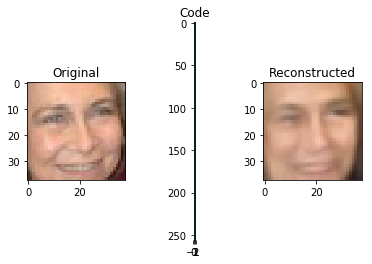

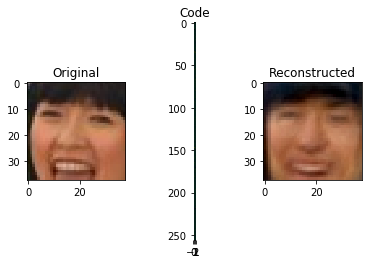

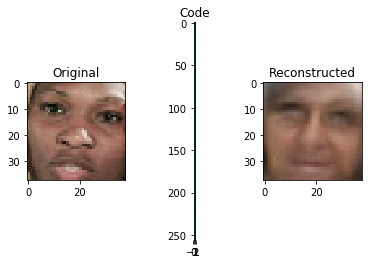

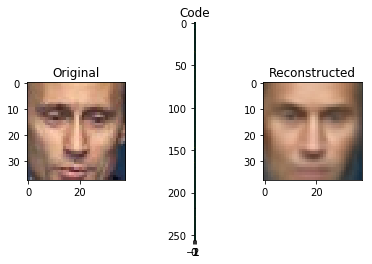

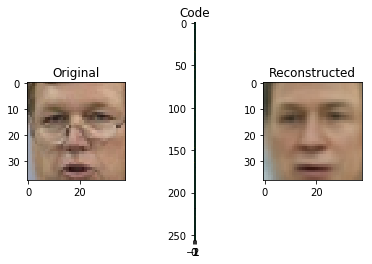

In [26]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [27]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Submit to Coursera

In [28]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(img_shape,code_size=71)
submit_autoencoder(submission, reconstruction_mse, 'nimish.sanghi@gmail.com', 'syHobFbfjxC3vsjJ')

Submitted to Coursera platform. See results on assignment page!


### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [ ]:
images = X_train
codes = <encode all images>
assert len(codes) == len(images)

In [ ]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
#smiles
show_similar(X_test[2])

In [ ]:
#ethnicity
show_similar(X_test[500])

In [ ]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


In [ ]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.